In [1]:
import warnings
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt 
from sklearn.cluster import MiniBatchKMeans

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=2)

### Loading the data

In [3]:
iris = datasets.load_iris()
data = iris.data
targets = iris.target

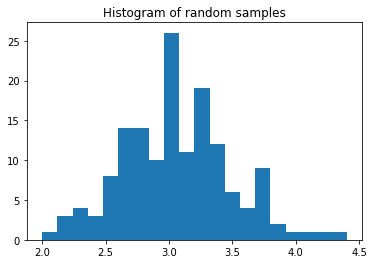

In [4]:
x = data[:, 1]  # a random variable
plt.hist(x, bins=20)
plt.title("Histogram of random samples")
plt.show()

In [5]:
mean_samples = np.mean(x)
std_samples = np.std(x)

In [6]:
# tmp = np.random.choice(x, 10, 50)
# tmp.shape

In [7]:
def compute_confidence(resampled_means, resampled_stds=None):
    
    # pivotal method:
    boots_mean = np.mean(resampled_means)
    if resampled_stds is None:
        boots_std = np.std(resampled_means)
    else:
        boots_std = np.std(resampled_stds)

    lbp = boots_mean - 1.96*boots_std  # left bound pivotal
    rbp = boots_mean + 1.96*boots_std  # right bound pivotal

    # Non-pivotal:
    lower_bound_index = int((len(resampled_means))*.025)
    higher_bound_index = int((len(resampled_means))*.975)
    resampled_mean_sorted = sorted(resampled_means,)

    lbn = resampled_mean_sorted[lower_bound_index]  # left bound non pivotal
    rbn = resampled_mean_sorted[higher_bound_index]  # right bound non pivotal
    
    return boots_mean, boots_std, lbp, rbp, lbn, rbn

# Bootstrapping

In [8]:
def bootstrapping(x, n_resample, n_bootstrap):
    
    """
        x, a 1-D array, representing the random samples.
        n_resample, an int, representing random sampling size
        n_bootstrap, an int, representing the number of 
        repeats in the bootstrapping procedure.

        Returns x_resampled_means, x_resampled_stds, boots_mean, boots_std, lbp, rbp, lbn, rbn, where
        x_resampled_means: list of means of resampled data(x) of the length n_resample,
        x_resampled_stds: list of standard deviations of resampled data(x) of the length n_resample,
        boots_mean: floating number, representing bootstrap mean --i.e mean of means)
        boots_std: floating number, representing bootstrap std --i.e std of stds.

    """

    np.random.seed(42)  # for the sake of reproducibility
    x_resampled_means, x_resampled_stds = [], []

    for _ in range(n_bootstrap):
        x_resampled = np.random.choice(x, size=n_resample, replace=True,)
        x_resampled_means.append(np.mean(x_resampled))
        x_resampled_stds.append(np.std(x_resampled))  # /np.sqrt(len(x)))

    boots_mean, boots_std, lbp, rbp, lbn, rbn = compute_confidence(resampled_means=x_resampled_means, resampled_stds=x_resampled_stds)

    return x_resampled_means, x_resampled_stds, boots_mean, boots_std, lbp, rbp, lbn, rbn

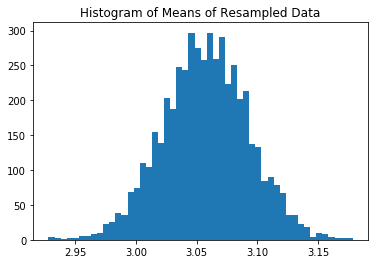

In [9]:
n_resample = 150
n_bootstrap = 5000

x_resampled_means, x_resampled_stds, x_boots_mean, \
x_boots_std, x_lbp, x_rbp, x_lbn, x_rbn = bootstrapping(x=x, n_resample=n_resample, n_bootstrap=n_bootstrap)

plt.hist(x_resampled_means, bins=50)
plt.title("Histogram of Means of Resampled Data")
plt.show()

The figure above looks quite Gaussian!

### Comparison

In [10]:
print("Samples Mean          : %.4f" % mean_samples, " Samples Std             : %.4f" % std_samples)
print("Bootstrap Mean        : %.4f" % x_boots_mean, " Bootstrap Std           : %.4f" % x_boots_std)
print(" ")
print("Left Bound-Pivotal    : %.4f" % x_lbp, " Right Bound-Pivotal     : %.4f" % x_rbp)
print("Left Bound-Non Pivotal: %.4f" % x_lbn, " Right Bound-Non Pivotal : %.4f" % x_rbn)

Samples Mean          : 3.0573  Samples Std             : 0.4344
Bootstrap Mean        : 3.0576  Bootstrap Std           : 0.0263
 
Left Bound-Pivotal    : 3.0060  Right Bound-Pivotal     : 3.1091
Left Bound-Non Pivotal: 2.9873  Right Bound-Non Pivotal : 3.1267


#### conslusion:

As one can see the original sample means lies between the left and right boundries both in pivotal and not pivotal methods.

# clustering

### data normalization

In [11]:
mean = np.mean(data, axis=0) # mean
rng = np.ptp(data, axis=0)  # range 
Y = np.divide(np.subtract(data, mean), rng) # normilizad
Y.shape
print(mean)

[5.84 3.06 3.76 1.2 ]


### Apply Minibatch clustering Algorithm

In [12]:
batch_size = 10
n_repeats = 10
centers = np.array([Y[1, :], Y[31, :], Y[52, :], Y[82,:], Y[111, :]])
n_clusters = 5
n_clusters

5

### Applying K-means (MiniBatch)

In [13]:
np.random.seed(42)
tmp = 0
clusters = {}
idxs = {}
cluster_means = {}
differences = {}

for i in range(n_repeats):
    mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, init=centers, n_init=1, )
    mbk.fit(Y)  # Compute K-mean
    ms = mbk.labels_
    
    # to chose the best clustering results regarding the inertia
    if i == 0 :
        tmp = mbk.inertia_
        delta = 0
    if i != 0:
        delta = tmp - mbk.inertia_
    if delta >= 0:
        tmp = mbk.inertia_
        
        for k in range(n_clusters):
            clusters[k] = data[np.where(ms==k)]
            idxs[k] = np.where(ms==k)[0]
        for k in range(n_clusters):
            cluster_means[k] = np.mean(clusters[k], axis=0)
            differences[k] = 100*(np.divide(np.subtract(cluster_means[k], mean), mean))

Let us investigate the cluster means and chose two clusters in which they have similar means

In [14]:
cluster_means

{0: array([4.73, 3.11, 1.45, 0.21]),
 1: array([5.23, 3.68, 1.47, 0.27]),
 2: array([6.28, 2.91, 4.89, 1.66]),
 3: array([5.6 , 2.59, 4.04, 1.24]),
 4: array([6.98, 3.13, 5.88, 2.18])}

In [15]:
differences

{0: array([-19.1 ,   1.69, -61.54, -82.19]),
 1: array([-10.58,  20.32, -60.75, -77.37]),
 2: array([ 7.4 , -4.91, 30.19, 38.69]),
 3: array([ -4.16, -15.28,   7.56,   3.28]),
 4: array([19.37,  2.45, 56.52, 81.65])}

In [16]:
c1_resampled_means, c1_resampled_stds, c1_boots_mean, \
c1_boots_std, c1_lbp, c1_rbp, c1_lbn, c1_rbn = bootstrapping(x=x[idxs[0]], n_resample=n_resample, n_bootstrap=n_bootstrap)

# plt.hist(c1_resampled_means, bins=50)
# plt.title("Histogram of Means of Resampled Data of 1st Cluster ")
# plt.show()

In [17]:
c2_resampled_means, c2_resampled_stds, c2_boots_mean, \
c2_boots_std, c2_lbp, c2_rbp, c2_lbn, c2_rbn = bootstrapping(x=x[idxs[4]], n_resample=n_resample, n_bootstrap=n_bootstrap)

# plt.hist(c2_resampled_means, bins=50)
# plt.title("Histogram of Means of Resampled Data of 2nd Cluster ")
# plt.show()

In [18]:
d12 = np.subtract(np.asarray(c1_resampled_means), np.asarray(c2_resampled_means))  # Difference between 1st and 2nd cluster
d1x = np.subtract(np.asarray(c1_resampled_means), np.asarray(x_resampled_means))  # Difference between 1st and x
d2x = np.subtract(np.asarray(c2_resampled_means), np.asarray(x_resampled_means))  # Difference between 1st and x

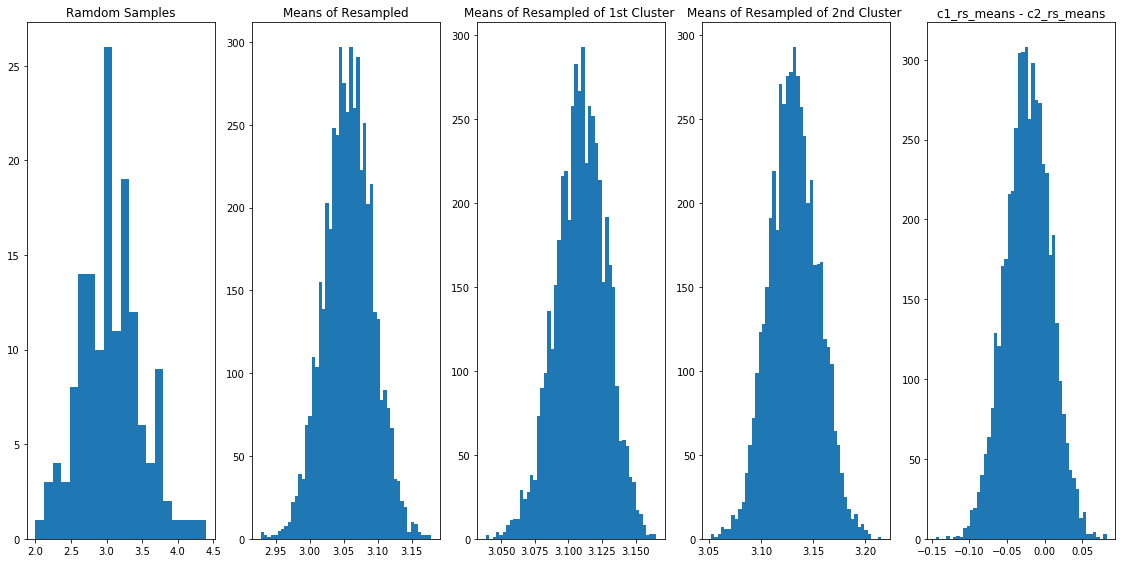

In [19]:
fig = plt.figure(figsize=(19.5, 9.5))

ax = fig.add_subplot(151)
plt.hist(x, bins=20)
plt.title("Ramdom Samples")


ax = fig.add_subplot(152)
plt.hist(x_resampled_means, bins=50)
plt.title("Means of Resampled")

ax = fig.add_subplot(153)
plt.hist(c1_resampled_means, bins=50)
plt.title("Means of Resampled of 1st Cluster ")

ax = fig.add_subplot(154)
plt.hist(c2_resampled_means, bins=50)
plt.title("Means of Resampled of 2nd Cluster ")

ax = fig.add_subplot(155)
plt.hist(d12, bins=50)
plt.title("c1_rs_means - c2_rs_means")  # rs stands for resampled data
plt.show()

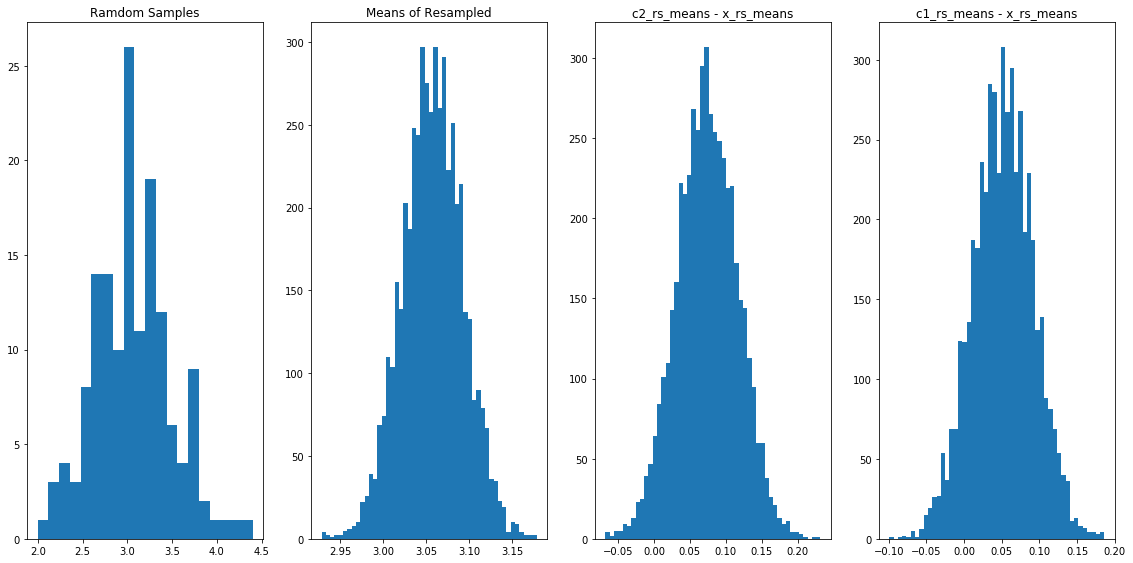

In [20]:
fig = plt.figure(figsize=(19.5, 9.5))

ax = fig.add_subplot(141)
plt.hist(x, bins=20)
plt.title("Ramdom Samples")

ax = fig.add_subplot(142)
plt.hist(x_resampled_means, bins=50)
plt.title("Means of Resampled")

# ax = fig.add_subplot(153)
# plt.hist(c1_resampled_means, bins=50)
# plt.title("Means of Resampled of 1st Cluster ")

ax = fig.add_subplot(143)
plt.hist(d2x, bins=50)
plt.title("c2_rs_means - x_rs_means")  # rs stands for resampled data

ax = fig.add_subplot(144)
plt.hist(d1x, bins=50)
plt.title("c1_rs_means - x_rs_means")  # rs stands for resampled data
plt.show()